# n_qubits_QVC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split 
from sklearn.datasets import make_blobs 
from sklearn import svm

from h import *
from W_unitary import *
from U_unitary import *
from qiskit_algorithms.optimizers import COBYLA, ADAM, SPSA, SLSQP, POWELL, L_BFGS_B, TNC, AQGD

%matplotlib inline
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 100
sns.set()

### helper functions

In [2]:
def make_meshgrid(x1, x2, h=0.2):
    
    x1_min, x1_max = x1.min() - 1, x1.max() + 1
    x2_min, x2_max = x2.min() - 1, x2.max() + 1
    x1x1, x2x2 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))
    
    return x1x1, x2x2


def training_split(X_train, y_train, n_batches):
    
    if len(X_train)%n_batches == 0:
        
        x = np.split(X_train, n_batches)
        y = np.split(y_train, n_batches)
        
    else:
        print('Warning: the training set must be divided into equally sized batches')
    
    return x, y

### dataset

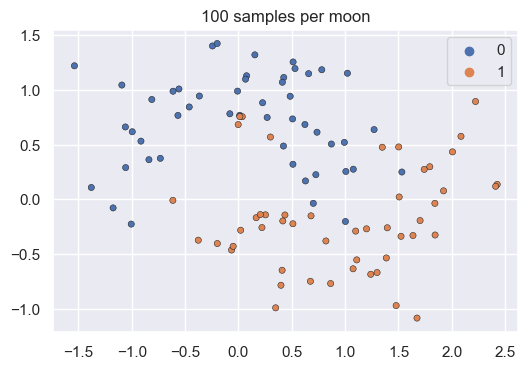

10
8

10
8


In [3]:
n_samples = 100
X, y = make_moons(n_samples, noise=0.3)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, marker="o", s=20, edgecolor="k", legend=True).set_title(str(n_samples) +" samples per moon")
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

n_batches = 10
x, y = training_split(X_train, y_train, n_batches)

print(len(x))
print(len(x[0]))
print()
print(len(y))
print(len(y[0]))

## Classical SVM

### linear kernel

In [4]:
linear_kernel = svm.LinearSVC()
linear_kernel.fit(X_train, y_train);

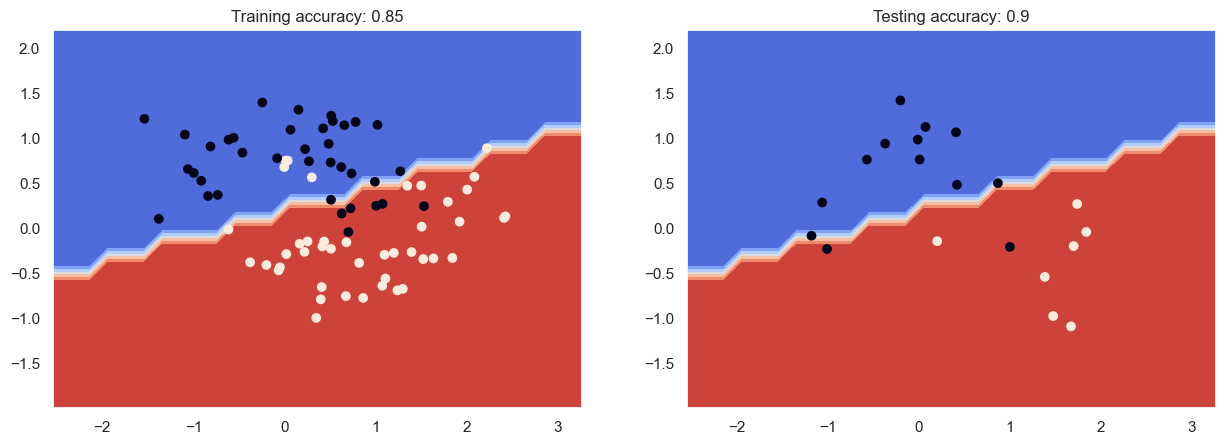

In [5]:
accuracy_train = linear_kernel.score(X_train, y_train)
accuracy_test = linear_kernel.score(X_test, y_test)

X_0, X_1 = X_train[:, 0], X_train[:, 1]
x0x0, x1x1 = make_meshgrid(X_0, X_1)
contours = linear_kernel.predict(np.c_[x0x0.ravel(), x1x1.ravel()])
contours = contours.reshape(x0x0.shape)

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].contourf(x0x0, x1x1, contours, cmap=plt.cm.coolwarm)
ax[0].scatter(X_0, X_1, c=y_train)
ax[0].set_title('Training accuracy: '+ str(accuracy_train));

ax[1].contourf(x0x0, x1x1, contours, cmap=plt.cm.coolwarm)
ax[1].scatter(X_test[:,0], X_test[:,1], c=y_test)
ax[1].set_title('Testing accuracy: '+ str(accuracy_test));

### gaussian kernel

In [6]:
gaussian_kernel = svm.SVC(gamma = 'scale')
gaussian_kernel.fit(X_train, y_train);

660

(22, 30)


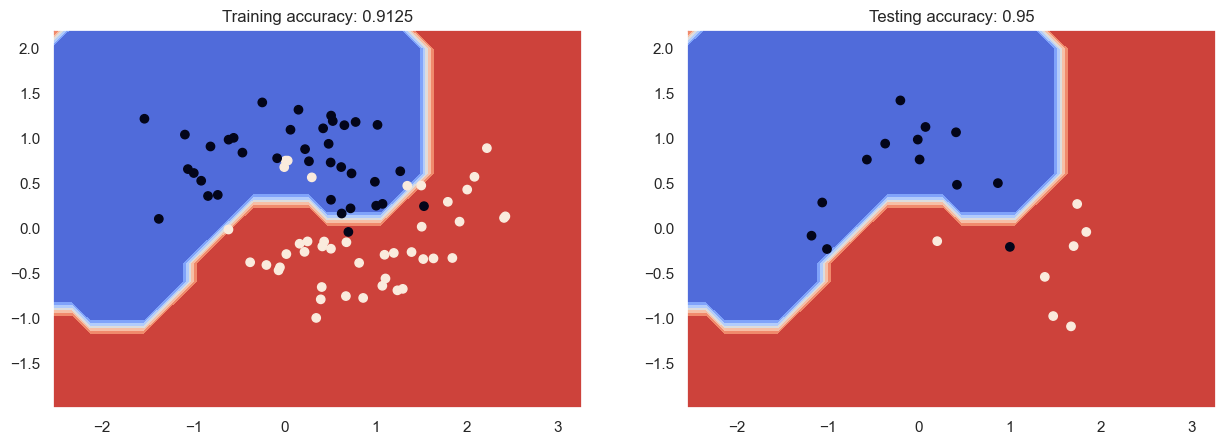

In [42]:
accuracy_train = gaussian_kernel.score(X_train, y_train)
accuracy_test = gaussian_kernel.score(X_test, y_test)

X_0, X_1 = X_train[:, 0], X_train[:, 1]
x0x0, x1x1 = make_meshgrid(X_0, X_1)
contours = gaussian_kernel.predict(np.c_[x0x0.ravel(), x1x1.ravel()])
contours = contours.reshape(x1x1.shape)

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].contourf(x0x0, x1x1, contours, cmap=plt.cm.coolwarm)
ax[0].scatter(X_0, X_1, c=y_train)
ax[0].set_title('Training accuracy: '+ str(accuracy_train));

ax[1].contourf(x0x0, x1x1, contours, cmap=plt.cm.coolwarm)
ax[1].scatter(X_test[:,0], X_test[:,1], c=y_test)
ax[1].set_title('Testing accuracy: '+ str(accuracy_test));

## Quantum SVM (explicit approach)

In [8]:
RANDOM_STATE = 42
seed = np.random.seed(RANDOM_STATE)

n = 2
d = 2

theta = 2*np.pi*np.random.random(n*d*3)
print('Initial parameters: '+ str(theta))

Initial parameters: [2.35330497 5.97351416 4.59925358 3.76148219 0.98029403 0.98014248
 0.3649501  5.44234523 3.77691701 4.44895122 0.12933619 6.09412333]


#### training

In [9]:
def MSE_loss(theta, y_train):
    
    new_y_train = []
    for i in range(0, len(y_train)):
        if y_train[i] == 0:
            new_y_train.append(-1)
        else:
            new_y_train.append(1)
    
    predictions = []
    for i in range(0, len(y_train)):
        predictions.append(h(X_train[i], theta, n, d, shots))
    
    error = []
    for i in range(0, len(predictions)):
        parity = predictions[i] - new_y_train[i]
        error.append(parity)

    norm = np.linalg.norm(error)
    
    return norm

In [10]:
epochs = n_batches
shots = 1024
thetas = []
tmp = []
for i in tqdm(range(0, epochs)):
    
    prediction = []
    data = x[i]
    labels = y[i]
    
    for i in range(0, len(data)):
        prediction.append(h(data[i], theta, n, d, shots))
        
        objective_function = lambda theta: MSE_loss(theta, labels)
        optimizer = COBYLA(maxiter=100)
        
        theta_opt = optimizer.minimize(objective_function, theta).x
    
    thetas.append(theta)
    tmp.append(prediction)
    theta = theta_opt
    


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:09<00:00, 18.90s/it]


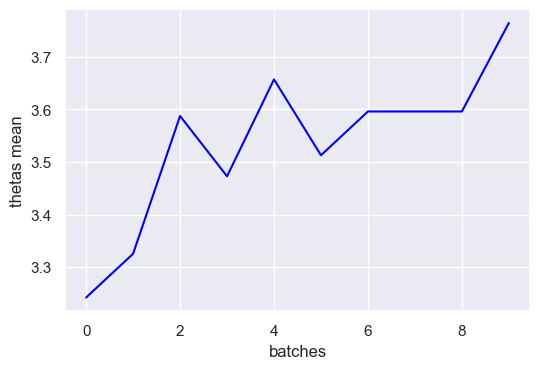

In [11]:
thetas_mean = []

for i in range(len(thetas)):
    thetas_mean.append(np.mean(thetas[i]))
    
#print(thetas)
#print(thetas_mean)

plt.plot(thetas_mean, color='blue')
plt.xlabel('batches')
plt.ylabel('thetas mean')
#plt.legend(loc=0, frameon=False)
plt.show()

#### testing

In [37]:
predictions = []
for i in range(0, len(tmp)):
    for j in range(0, len(tmp[i])):
        predictions.append(tmp[i][j])

h_new = []
for i in range(0, len(y_train)):
    h_new.append(h(X_train[i], theta_opt, n, d, shots))

accuracy_train = 1 - ( (np.abs(sum(2*y_train-1-predictions))/2) / len(y_train) )
print('Training accuracy: '+ str(accuracy_train))
#print(np.abs(sum(2*y_train-1-predictions))/2)
#print(sum(2*y_train-1-h_new))
#print(len(y_train))

Training accuracy: 0.975


In [38]:
h_test = []
for i in range(0, len(y_test)):
    h_test.append(h(X_test[i], theta_opt, n, d, shots))

accuracy_test = 1 - (np.abs((sum(2*y_test-1-h_test)/2)) / len(y_test) )
print('Testing accuracy: '+ str(accuracy_test))
#print(np.abs(sum(2*y_test-1-h_test))/2)
#print(len(y_test))

Testing accuracy: 0.8


In [43]:
X_0, X_1 = X_train[:, 0], X_train[:, 1]
x0x0, x1x1 = make_meshgrid(X_0, X_1)
print(np.c_[x0x0.ravel(), x1x1.ravel()].shape)
#contours = gaussian_kernel.predict(np.c_[x0x0.ravel(), x1x1.ravel()])
contours = np.array(predictions)
contours = contours.reshape(x0x0.shape)

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].contourf(x0x0, x1x1, contours, cmap=plt.cm.coolwarm)
ax[0].scatter(X_0, X_1, c=y_train)
ax[0].set_title('Training accuracy: '+ str(accuracy_train));

ax[1].contourf(x0x0, x1x1, new_contours, cmap=plt.cm.coolwarm)
ax[1].scatter(X_test[:,0], X_test[:,1], c=y_test)
ax[1].set_title('Testing accuracy: '+ str(accuracy_test));

(660, 2)


ValueError: cannot reshape array of size 80 into shape (22,30)